## Training Script

In [2]:
!pip install -r requirement.txt

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'

## Dataset Preparation

In [4]:
import torch
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score
from pytorch_lightning import LightningModule, Trainer
import os
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from PIL import Image
import scipy.io
import numpy as np

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "wbc"

image_path

WindowsPath('data/wbc')

In [6]:
data_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 ,
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2720659834.py, line 6)

In [68]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "valid"

train_dir, test_dir

(WindowsPath('data/wbc/train'), WindowsPath('data/wbc/valid'))

In [69]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 156
    Root location: data\wbc\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 156
    Root location: data\wbc\valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [70]:
image, label = next(iter(train_data))

In [71]:
image.size(), label

(torch.Size([3, 224, 224]), 0)

In [72]:
class_names = train_data.classes
class_names

['Basofil', 'Eosinofil', 'Limfosit', 'Monosit', 'Neutrofil']

In [73]:
class_dict = train_data.class_to_idx
class_dict

{'Basofil': 0, 'Eosinofil': 1, 'Limfosit': 2, 'Monosit': 3, 'Neutrofil': 4}

In [74]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=128, # how many samples per batch?
                              num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=128,
                             num_workers=0,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x288e3d7ac50>,
 <torch.utils.data.dataloader.DataLoader at 0x288f1df1010>)

In [75]:
images, labels = next(iter(train_dataloader))

In [76]:
images.size(), labels.size()

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [77]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)



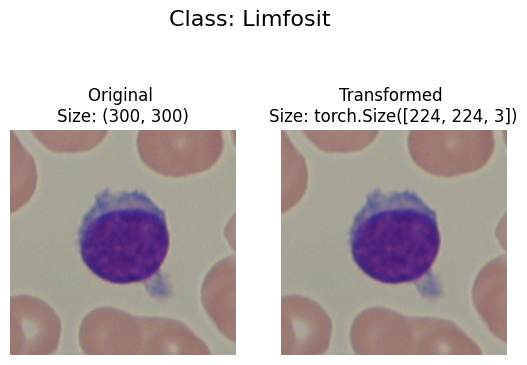

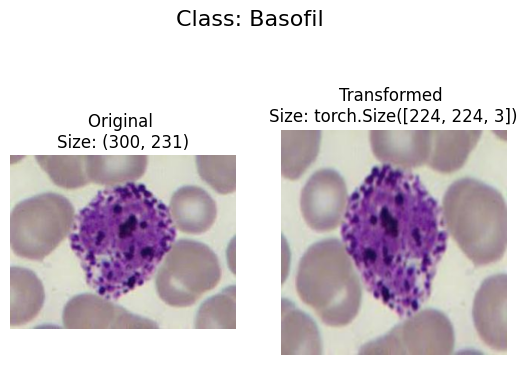

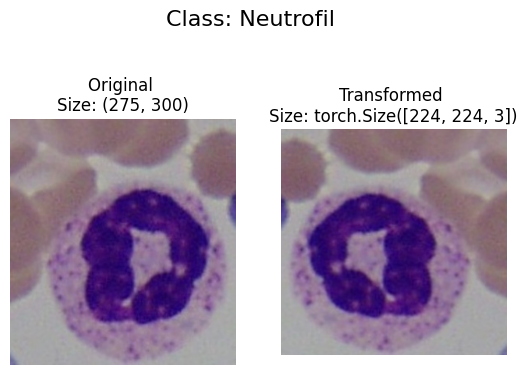

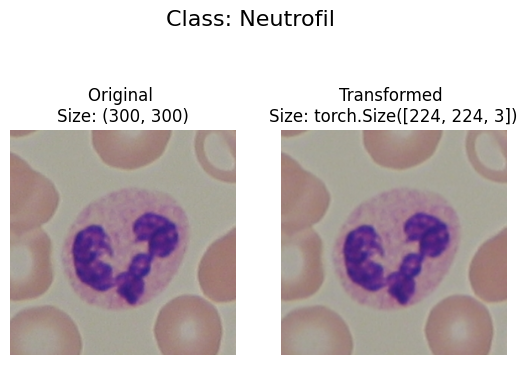

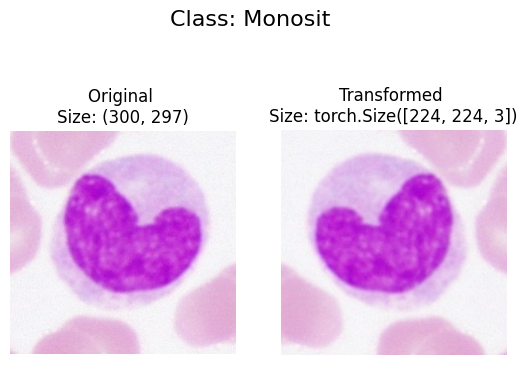

In [78]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=5)

## Training

In [79]:
class MyCustomModel(nn.Module):
    def __init__(self, num_classes):
        super(MyCustomModel, self).__init__()
        self.model = models.resnet50(weights="DEFAULT")
        in_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.model(x)
        return x

In [80]:
torch.manual_seed(42)
model_1 = MyCustomModel(num_classes=len(train_data.classes)).to(device)
model_1

MyCustomModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [81]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[ 0.0020, -0.0560, -0.0563, -0.2027,  0.0391]])

Output prediction probabilities:
tensor([[0.2110, 0.1991, 0.1990, 0.1719, 0.2190]])

Output prediction label:
tensor([4])

Actual label:
2


In [82]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [83]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [84]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 10):

    best_acc = 0
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), "best.pt")
            print(f"saving model with test accuracy: {test_acc}")

        # 5. Update results dictionary

        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [85]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 30

# Recreate an instance of TinyVGG
model_1.to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.0001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [01:53<54:53, 113.58s/it]

Epoch: 1 | train_loss: 1.5922 | train_acc: 0.2561 | test_loss: 1.5658 | test_acc: 0.2483
saving model with test accuracy: 0.24832589285714285


  7%|▋         | 2/30 [03:34<49:24, 105.89s/it]

Epoch: 2 | train_loss: 1.3835 | train_acc: 0.7310 | test_loss: 1.5618 | test_acc: 0.2366


 10%|█         | 3/30 [05:38<51:33, 114.57s/it]

Epoch: 3 | train_loss: 1.2808 | train_acc: 0.7416 | test_loss: 1.5567 | test_acc: 0.2679
saving model with test accuracy: 0.26785714285714285


 13%|█▎        | 4/30 [07:52<52:55, 122.13s/it]

Epoch: 4 | train_loss: 1.1659 | train_acc: 0.8343 | test_loss: 1.5536 | test_acc: 0.2539


 17%|█▋        | 5/30 [09:38<48:25, 116.24s/it]

Epoch: 5 | train_loss: 1.0003 | train_acc: 0.8878 | test_loss: 1.5432 | test_acc: 0.2539
Epoch: 6 | train_loss: 0.8668 | train_acc: 0.8739 | test_loss: 1.5237 | test_acc: 0.2718
saving model with test accuracy: 0.27176339285714285


 23%|██▎       | 7/30 [13:16<43:14, 112.81s/it]

Epoch: 7 | train_loss: 0.7722 | train_acc: 0.9448 | test_loss: 1.5095 | test_acc: 0.3231
saving model with test accuracy: 0.32310267857142855
Epoch: 8 | train_loss: 0.6357 | train_acc: 0.9665 | test_loss: 1.4971 | test_acc: 0.3588
saving model with test accuracy: 0.3588169642857143


 30%|███       | 9/30 [17:25<41:39, 119.01s/it]

Epoch: 9 | train_loss: 0.6994 | train_acc: 0.8929 | test_loss: 1.4709 | test_acc: 0.3783
saving model with test accuracy: 0.3783482142857143


 33%|███▎      | 10/30 [19:29<40:07, 120.35s/it]

Epoch: 10 | train_loss: 0.5350 | train_acc: 0.9743 | test_loss: 1.4546 | test_acc: 0.4235
saving model with test accuracy: 0.42354910714285715
Epoch: 11 | train_loss: 0.4529 | train_acc: 0.9961 | test_loss: 1.4264 | test_acc: 0.4648
saving model with test accuracy: 0.46484375


 40%|████      | 12/30 [23:39<36:44, 122.45s/it]

Epoch: 12 | train_loss: 0.3777 | train_acc: 0.9821 | test_loss: 1.3969 | test_acc: 0.4844
saving model with test accuracy: 0.484375


 43%|████▎     | 13/30 [26:01<36:22, 128.41s/it]

Epoch: 13 | train_loss: 0.3274 | train_acc: 1.0000 | test_loss: 1.3591 | test_acc: 0.4916
saving model with test accuracy: 0.4916294642857143


 47%|████▋     | 14/30 [28:14<34:35, 129.73s/it]

Epoch: 14 | train_loss: 0.2851 | train_acc: 0.9821 | test_loss: 1.3101 | test_acc: 0.5151
saving model with test accuracy: 0.5150669642857143


 50%|█████     | 15/30 [30:36<33:20, 133.34s/it]

Epoch: 15 | train_loss: 0.2136 | train_acc: 1.0000 | test_loss: 1.2632 | test_acc: 0.5073
Epoch: 16 | train_loss: 0.1933 | train_acc: 1.0000 | test_loss: 1.1896 | test_acc: 0.5368


 53%|█████▎    | 16/30 [32:57<31:39, 135.71s/it]

saving model with test accuracy: 0.5368303571428571
Epoch: 17 | train_loss: 0.1695 | train_acc: 1.0000 | test_loss: 1.1267 | test_acc: 0.5843


 57%|█████▋    | 17/30 [35:02<28:42, 132.54s/it]

saving model with test accuracy: 0.5842633928571428
Epoch: 18 | train_loss: 0.1137 | train_acc: 1.0000 | test_loss: 1.0018 | test_acc: 0.7132


 60%|██████    | 18/30 [37:30<27:27, 137.28s/it]

saving model with test accuracy: 0.7131696428571428
Epoch: 19 | train_loss: 0.0759 | train_acc: 1.0000 | test_loss: 0.8944 | test_acc: 0.7467
saving model with test accuracy: 0.7466517857142857


 63%|██████▎   | 19/30 [39:34<24:25, 133.23s/it]

Epoch: 20 | train_loss: 0.0687 | train_acc: 1.0000 | test_loss: 0.7799 | test_acc: 0.7762
saving model with test accuracy: 0.7762276785714286


 67%|██████▋   | 20/30 [41:32<21:25, 128.57s/it]

Epoch: 21 | train_loss: 0.0651 | train_acc: 1.0000 | test_loss: 0.6564 | test_acc: 0.8577


 70%|███████   | 21/30 [43:42<19:20, 128.95s/it]

saving model with test accuracy: 0.8577008928571428


 73%|███████▎  | 22/30 [46:01<17:35, 131.98s/it]

Epoch: 22 | train_loss: 0.0465 | train_acc: 1.0000 | test_loss: 0.4912 | test_acc: 0.8733
saving model with test accuracy: 0.8733258928571428


 77%|███████▋  | 23/30 [48:07<15:12, 130.34s/it]

Epoch: 23 | train_loss: 0.0341 | train_acc: 1.0000 | test_loss: 0.4774 | test_acc: 0.8376


 80%|████████  | 24/30 [50:24<13:14, 132.37s/it]

Epoch: 24 | train_loss: 0.0310 | train_acc: 1.0000 | test_loss: 0.3943 | test_acc: 0.8633


 83%|████████▎ | 25/30 [52:21<10:38, 127.78s/it]

Epoch: 25 | train_loss: 0.0241 | train_acc: 1.0000 | test_loss: 0.3209 | test_acc: 0.8633


 87%|████████▋ | 26/30 [54:48<08:53, 133.43s/it]

Epoch: 26 | train_loss: 0.0327 | train_acc: 1.0000 | test_loss: 0.2769 | test_acc: 0.8850
saving model with test accuracy: 0.8850446428571428
Epoch: 27 | train_loss: 0.0301 | train_acc: 1.0000 | test_loss: 0.1511 | test_acc: 0.9386
saving model with test accuracy: 0.9386160714285714


 93%|█████████▎| 28/30 [59:05<04:22, 131.31s/it]

Epoch: 28 | train_loss: 0.0117 | train_acc: 1.0000 | test_loss: 0.1054 | test_acc: 0.9604
saving model with test accuracy: 0.9603794642857143


 97%|█████████▋| 29/30 [1:01:21<02:12, 132.73s/it]

Epoch: 29 | train_loss: 0.0275 | train_acc: 1.0000 | test_loss: 0.0816 | test_acc: 0.9643
saving model with test accuracy: 0.9642857142857143


100%|██████████| 30/30 [1:03:33<00:00, 127.12s/it]

Epoch: 30 | train_loss: 0.0176 | train_acc: 1.0000 | test_loss: 0.0442 | test_acc: 1.0000
saving model with test accuracy: 1.0
Total training time: 3813.771 seconds


In [1]:
plt.plot(his)

NameError: name 'model_0_results' is not defined